### Exploring the annotated data.

In [49]:
from datasets import load_dataset, disable_caching
import pandas as pd
import os
from tqdm.auto import tqdm

# can infer the generic loader script this easily
disable_caching()
# cache location [click](%userprofile%/.cache/huggingface/datasets)
# needs force_redownload to avoid loading incorrect cached stuff
shader20k_files = os.listdir("./data/annotated")
# print(shader20k_files)
shader20k_files = [f"./data/annotated/{f}" for f in shader20k_files if f.startswith("20k")]
# ds = load_dataset("json", data_dir="./data/annotated", download_mode="force_redownload", cache_dir=None)
ds = load_dataset("json", data_files=shader20k_files, download_mode="force_redownload", cache_dir=None)
# ds = load_dataset("json", data_dir="./data/annotated_test/", download_mode="force_redownload", cache_dir=None)
df = ds["train"].to_pandas()
# read "date" column as unix timestamp
df["date"] = pd.to_datetime(df["date"].astype(int), unit="s")
ds

Resolving data files:   0%|          | 0/95 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/19622 [00:00<?, ? examples/s]

PermissionError: [WinError 5] Zugriff verweigert: 'C:/Users/Jan/.cache/huggingface/datasets/json/default-1430a2fe1185e6f4/0.0.0/7483f22a71512872c377524b97484f6d20c275799bb9e7cd8fb3198178d8220a\\json-train.arrow'

In [ ]:
# fewer than 6k unique authors in shaders20k
df["author"].nunique()

NameError: name 'df' is not defined

In [ ]:
#redo the df

df = ds["train"].to_pandas()
# read "date" column as unix timestamp
df["date"] = pd.to_datetime(df["date"].astype(int), unit="s")
#

In [ ]:
df["test"].value_counts().head(10)

test
ok          11324
error        5014
timeout      3260
timedout       24
Name: count, dtype: int64

In [ ]:
# list of permissive licenses like: https://huggingface.co/datasets/bigcode/the-stack-v2/blob/main/license_stats.csv (gated?)
# maybe this instead: https://huggingface.co/datasets/bigcode/the-stack/blob/main/licenses.json
# seems to be the one they actually use: https://huggingface.co/datasets/bigcode-data/license_list/resolve/main/permissive_licenses.txt 

import requests
permissive_list = requests.get("https://huggingface.co/datasets/bigcode-data/license_list/resolve/main/permissive_licenses.txt").content.decode("utf-8").split()
permissive_list = [l.lower() for l in permissive_list]

print(len(permissive_list))

824


In [ ]:
# filtering down the dataset and keeping track of the numbers
print(ds["train"].unique("license"))
# filter permissive licenses
filtered_ds = ds["train"]
num_all = len(filtered_ds)
print(f"{num_all=}")
filtered_ds = filtered_ds.filter(lambda x: x["published"] == "Public API") # only take shaders published to the API
num_public_api = len(filtered_ds)
print(f"{num_public_api=}")
filtered_ds = filtered_ds.filter(lambda x: x["license"] in permissive_list + ["CC-BY-NC-SA-3.0"]) # permissive or base case(not actually permissive...) what about those AND and OR classifications?
num_permissive = len(filtered_ds)
print(f"{num_permissive=}")
filtered_ds = filtered_ds.filter(lambda x: x["test"] == "ok") # ok means it actually runs, valid was just that naga didn't error... but this also has issues
num_working = len(filtered_ds)
print(f"{num_working=}")
filtered_ds

['CC-BY-NC-SA-3.0', 'cc-by-nc-sa-3.0', 'bsd-new', 'mit', 'cc-by-4.0', 'proprietary-license', 'cc-by-nc-nd-3.0', 'bsd-simplified', 'cc0-1.0', 'unknown-license-reference', 'public-domain', 'apache-2.0', 'cc-by-nc-sa-4.0', 'agpl-3.0', 'cc-by-sa-3.0', 'cc-by-3.0', 'cc-by-sa-2.5', 'cc-by-sa-4.0', 'cc-by-sa-4.0 WITH generic-exception', 'cc-by-3.0 AND mit', 'cc-by-nc-sa-2.0', 'cc-by-nc-sa-3.0 AND proprietary-license', 'wtfpl-2.0', 'gpl-3.0', 'cc-by-4.0 OR cc-by-3.0', 'beerware', 'gpl-3.0-plus OR cc-by-sa-3.0', 'unlicense', 'cc-by-nc-nd-4.0', 'warranty-disclaimer', 'x11', 'gpl-3.0-plus', 'cc-by-nc-4.0', 'cc-by-2.5', 'cc0-1.0 OR openssl-ssleay OR apache-2.0', 'gpl-2.0', 'gpl-2.0-plus', 'cc-by-nc-3.0', 'gpl-1.0-plus', 'artistic-2.0', 'cc-sampling-plus-1.0']
num_all=19622


Filter:   0%|          | 0/19622 [00:00<?, ? examples/s]

num_public_api=7263


Filter:   0%|          | 0/7263 [00:00<?, ? examples/s]

num_permissive=6146


Filter:   0%|          | 0/6146 [00:00<?, ? examples/s]

num_working=3425


Dataset({
    features: ['id', 'name', 'author', 'description', 'tags', 'likes', 'viewed', 'published', 'date', 'time_retrieved', 'image_code', 'image_inputs', 'common_code', 'sound_code', 'sound_inputs', 'buffer_a_code', 'buffer_a_inputs', 'buffer_b_code', 'buffer_b_inputs', 'buffer_c_code', 'buffer_c_inputs', 'buffer_d_code', 'buffer_d_inputs', 'cube_a_code', 'cube_a_inputs', 'thumbnail', 'access', 'license', 'functions', 'test'],
    num_rows: 3425
})

In [ ]:
# seems to never contain any common pass? or my preprocessing is wrong.
print(df["common_code"].unique()) 

# see how many shaders contain buffer passes (seemingly none?)
ds["train"].filter(lambda x: x["buffer_a_code"] + x["buffer_b_code"] + x["buffer_c_code"] + x["buffer_d_code"] != "")

['']


Filter:   0%|          | 0/19622 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'name', 'author', 'description', 'tags', 'likes', 'viewed', 'published', 'date', 'time_retrieved', 'image_code', 'image_inputs', 'common_code', 'sound_code', 'sound_inputs', 'buffer_a_code', 'buffer_a_inputs', 'buffer_b_code', 'buffer_b_inputs', 'buffer_c_code', 'buffer_c_inputs', 'buffer_d_code', 'buffer_d_inputs', 'cube_a_code', 'cube_a_inputs', 'thumbnail', 'access', 'license', 'functions', 'test'],
    num_rows: 0
})

<Axes: title={'center': 'license'}, xlabel='date'>

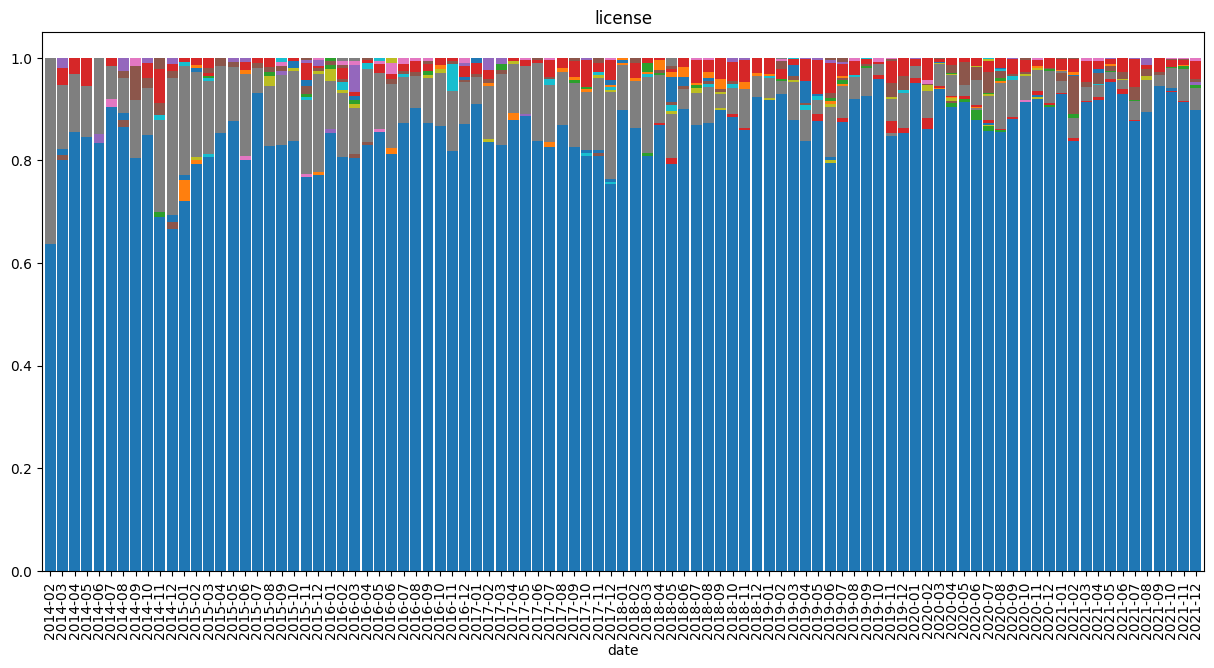

In [24]:
def plot_per_month(column, stretched=False, data=df, **kwargs):
    feature_df = data["date"].groupby([data["date"].dt.to_period("M"), data[column]]).count().unstack()
    if stretched:
        feature_df = feature_df.div(feature_df.sum(axis=1), axis=0)
    return feature_df.plot(kind="bar", stacked=True, figsize=(15,7), title=column, width=.9, **kwargs)
    
plot_per_month("license", True, legend=False)

<Axes: title={'center': 'published'}, xlabel='date'>

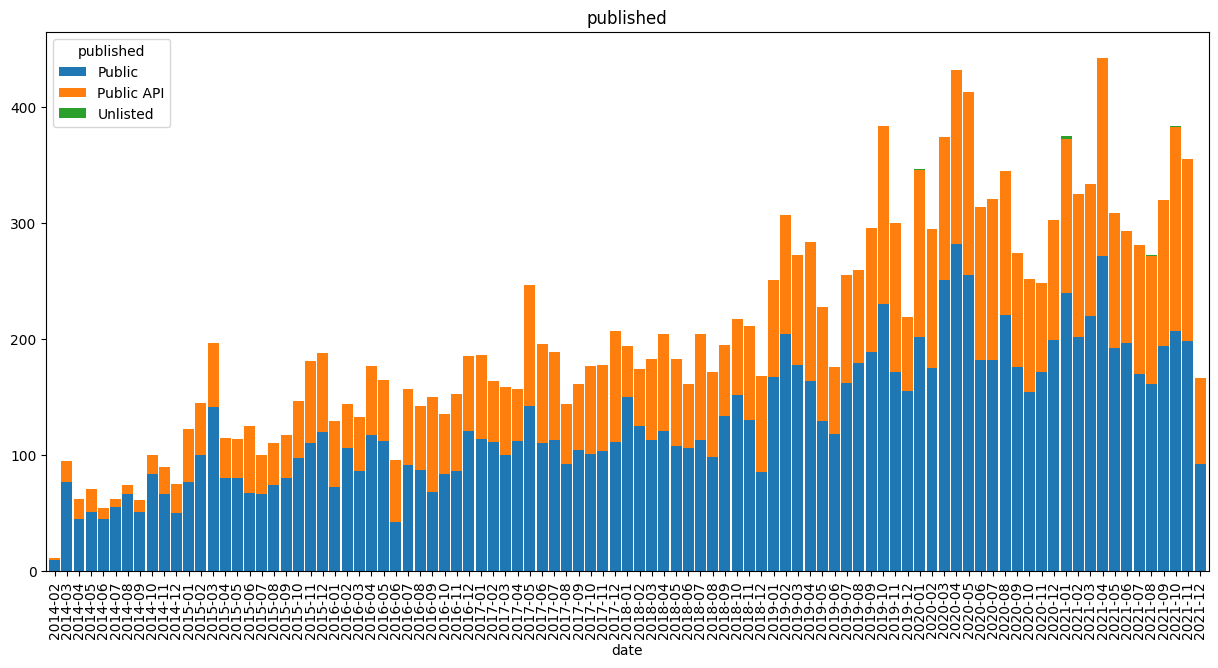

In [ ]:
plot_per_month("published", False)

<Axes: title={'center': 'test'}, xlabel='date'>

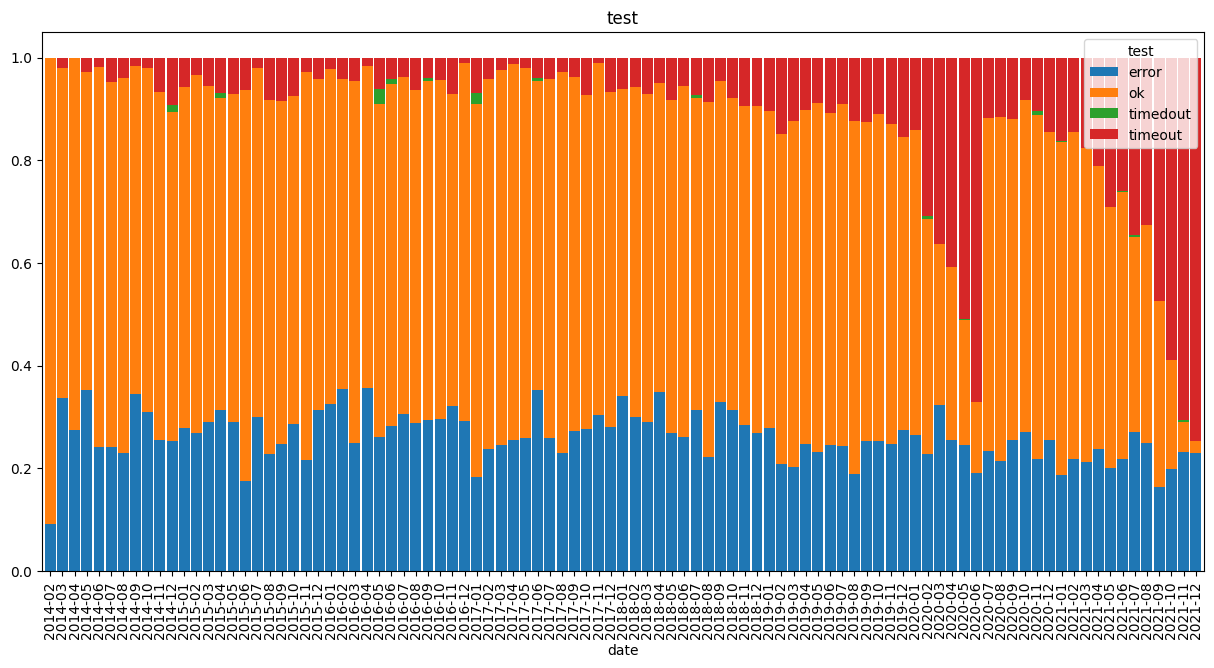

In [ ]:
# currently in development, another filtering step.
plot_per_month("test", stretched=True, legend=True)

In [ ]:
df["num_functions"] = df["functions"].apply(len)
df["num_functions"].describe()

count    19622.000000
mean         7.946234
std         10.261134
min          0.000000
25%          2.000000
50%          5.000000
75%         10.000000
max        344.000000
Name: num_functions, dtype: float64

<Axes: title={'center': 'num_inputs'}, xlabel='date'>

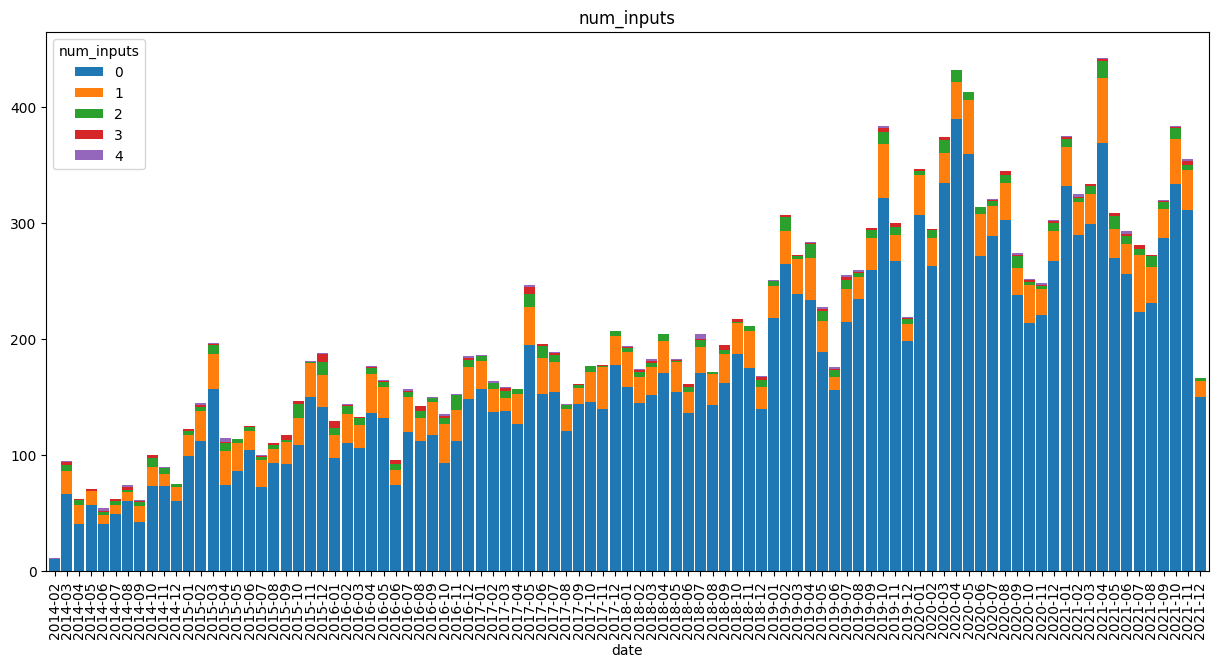

In [ ]:
df["num_inputs"] = df["image_inputs"].apply(len)
plot_per_month("num_inputs", stretched=False, legend=True)

In [ ]:
# these cases might be parsing failures? seem to always use macros inside functions or something.
# some use no functions but Main(){...} which seems to work in glsl but not viable for our dataset
from annotate import PARSER
print(PARSER.parse(bytes(df["image_code"][19616],encoding="utf-8")).root_node.has_error)
df.loc[df["num_functions"] == 0]

False


,id,name,author,description,tags,likes,viewed,published,date,time_retrieved,...,buffer_d_inputs,cube_a_code,cube_a_inputs,thumbnail,access,license,functions,test,num_functions,num_inputs
25,4s23Wc,pfhrector,pfhunk,80s vector graphics inspired kaliset,"[2d, fractal, kaliset]",7,791,Public,2014-03-11 02:44:55,2021-10-01,...,[],,[],https://www.shadertoy.com/media/shaders/4s23Wc...,shaders20k,CC-BY-NC-SA-3.0,[],ok,0,0
62,Md23DV,GLSL 2D Tutorials,vug,28 tutorials on writing pixel shaders at Shade...,[tutorial],581,48910,Public,2014-03-08 20:58:49,2021-10-01,...,[],,[],https://www.shadertoy.com/media/shaders/Md23DV...,shaders20k,CC-BY-NC-SA-3.0,[],error,0,3
424,XsSSRz,Tiny Ray Marcher 3.0,Aaro,Oh its on. I'm sure comment section will be fu...,"[reflection, ray, shadow, marching, tiny]",4,267,Public,2014-08-15 14:12:07,2021-10-01,...,[],,[],https://www.shadertoy.com/media/shaders/XsSSRz...,shaders20k,CC-BY-NC-SA-3.0,[],ok,0,0
565,Ms2XWw,Twist Scroller,ac3t1ne,Greetz!,"[2d, retro, amiga, ac3t1ne, scroller]",14,966,Public,2014-10-10 18:41:28,2021-10-01,...,[],,[],https://www.shadertoy.com/media/shaders/Ms2XWw...,shaders20k,CC-BY-NC-SA-3.0,[],ok,0,0
613,ld2SW3,A Pattern Emerges,okro,Takes a few seconds.,[dots],1,141,Public,2014-11-23 05:04:25,2021-10-01,...,[],,[],https://www.shadertoy.com/media/shaders/ld2SW3...,shaders20k,CC-BY-NC-SA-3.0,[],ok,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19362,Nty3Ry,Plotting by dmc3105,dmc3105,my first shader,[math],1,94,Public API,2021-11-26 15:06:50,2021-10-01,...,[],,[],https://www.shadertoy.com/media/shaders/Nty3Ry...,shaders20k,CC-BY-NC-SA-3.0,[],timeout,0,0
19422,std3zl,Lava Blob,Moustave,o,[yayyy],2,25,Public,2021-11-10 18:04:19,2021-10-01,...,[],,[],https://www.shadertoy.com/media/shaders/std3zl...,shaders20k,CC-BY-NC-SA-3.0,[],error,0,0
19479,7t3SDM,Tetragrammaton,4eckme,https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D1%...,[tetragrammaton],26,1891,Public,2021-12-11 07:59:44,2021-10-01,...,[],,[],https://www.shadertoy.com/media/shaders/7t3SDM...,shaders20k,CC-BY-NC-SA-3.0,[],timeout,0,0
19606,stKGDc,tiny voxels,flockaroo,...originally done in twigl.app (266 chars the...,"[voxel, golfing, tinycode]",21,305,Public API,2021-12-02 21:22:22,2021-10-01,...,[],,[],https://www.shadertoy.com/media/shaders/stKGDc...,shaders20k,cc-by-nc-sa-3.0,[],timeout,0,0


In [ ]:
# TODO: refactor into a generator because I dislike the current shape. but figure out how batching and threadding works then?
# part of the filter.py or prepare.py script that will be done soon.
def split_functions(batch):
    # per function fields
    comments, headers, docstrings, bodies = [],[],[],[]
    # per document fields
    full_code, funcs, ids, dates = [],[],[],[]
    for code, func_bytes, shader_id, shader_date in zip(batch["image_code"], batch["functions"], batch["id"], batch["date"]):
        row_code = bytes(code,encoding="utf-8")
        for start_comment, start_header, end_header, end_docstring, end_function in func_bytes:
            comments.append(row_code[start_comment:start_header].decode(encoding="utf-8")),
            headers.append(row_code[start_header:end_header].decode(encoding="utf-8")),
            docstrings.append(row_code[end_header:end_docstring].decode(encoding="utf-8")),
            bodies.append(row_code[end_docstring:end_function].decode(encoding="utf-8")),
            full_code.append(row_code.decode(encoding="utf-8")),
            funcs.append((start_comment, start_header, end_header, end_docstring, end_function))
            ids.append(shader_id)
            dates.append(shader_date)
    return {
            "comment": comments,
            "header": headers,
            "docstring": docstrings,
            "body": bodies,
            "full_code": full_code,
            "func_bytes": funcs,
            "id": ids,
            "date": dates,
            }


# func_ds = ds.map(split_functions, batched=True, remove_columns=ds["train"].column_names) # full dataset to functions
func_ds = filtered_ds.map(split_functions, batched=True, remove_columns=filtered_ds.column_names) # only permissive shaders (the whole 20k set is single pass without common...)
if "train" in func_ds:
    func_ds = func_ds["train"]
func_ds

Map:   0%|          | 0/3425 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'date', 'comment', 'header', 'docstring', 'body', 'full_code', 'func_bytes'],
    num_rows: 16600
})

In [ ]:
func_df = func_ds.to_pandas()
func_df["date"] = pd.to_datetime(func_ds["date"], unit="s") #didn't copy correctly?
func_df.head() 

C:\Users\Jan\AppData\Local\Temp\ipykernel_4256\1011214885.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  func_df["date"] = pd.to_datetime(func_ds["date"], unit="s") #didn't copy correctly?


,id,date,comment,header,docstring,body,full_code,func_bytes
0,XsS3DV,2014-02-28 22:11:31,,"vec2 center ( vec2 border , vec2 offset , vec2...",,\n\tvec2 c;\n\tif ( vel.x == 0.0 && vel.y == 0...,\nfloat k = 20.0;\nfloat field = 0.0;\nvec2 co...,"[49, 49, 103, 103, 506]"
1,XsS3DV,2014-02-28 22:11:31,,"void circle ( float r , vec3 col , vec2 offset...",,\n\tvec2 pos = coord.xy / iResolution.y;\n\tfl...,\nfloat k = 20.0;\nfloat field = 0.0;\nvec2 co...,"[508, 508, 569, 569, 797]"
2,XsS3DV,2014-02-28 22:11:31,,"vec3 band ( float shade, float low, float high...",,\n\n\tif ( (shade >= low) && (shade <= high) )...,\nfloat k = 20.0;\nfloat field = 0.0;\nvec2 co...,"[800, 800, 872, 872, 1067]"
3,XsS3DV,2014-02-28 22:11:31,,vec3 gradient ( float shade ) {,,\n\tvec3 colour = vec3( (sin(iTime/2.0)*0.25)+...,\nfloat k = 20.0;\nfloat field = 0.0;\nvec2 co...,"[1069, 1069, 1100, 1100, 1876]"
4,XsS3DV,2014-02-28 22:11:31,,"void mainImage( out vec4 fragColor, in vec2 fr...",,\n\n coord = fragCoord;\n \n\tcircle ( ....,\nfloat k = 20.0;\nfloat field = 0.0;\nvec2 co...,"[1878, 1878, 1935, 1935, 2619]"


In [ ]:
func_df["has_comment"] = func_df["comment"] != ""
func_df["has_docstring"] = func_df["docstring"] != ""
# func_df["model_ctx"] = func_df["comment"] + func_df["header"] + func_df["comment"]
# how many functions are there, and what is the share of comments, 

xtab = pd.crosstab(func_df["has_comment"], func_df["has_docstring"], margins=True)
print(f"functions with context = {xtab.iloc[-1,-1] - xtab.iloc[0,0]}")
xtab

# for the permissive subset of shaders 21k the number goes down to like 253 for both... and 150 for valid shaders only.

functions with context = 3822


has_docstring,False,True,All
has_comment,,,
False,12778,1152,13930
True,2341,329,2670
All,15119,1481,16600


In [ ]:
# FINDING: only about half the comments are unique.
# some frequent comment looks like a template maybe? should investigate
print(func_df["comment"].nunique())
func_df["comment"].value_counts(sort=True, ascending=False).head(10)

1941


comment
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                13930
//----------------------------------------------------------------------------------------\n//  3 out, 1 in...\n                                                                                                                                                                                                                                                                                                                                                                          

In [ ]:
# FINDING = only about a third of function-headers are unique?
# it's expect to have one mainImage function per renderpass... but they are just whitesapce variable here - maybe we skip them in general
print(func_df["header"].nunique())
func_df["header"].value_counts(sort=True, ascending=False).head(10)

9110


header
void mainImage( out vec4 fragColor, in vec2 fragCoord )\n{    1979
void mainImage( out vec4 fragColor, in vec2 fragCoord ) {      175
void mainImage(out vec4 fragColor, in vec2 fragCoord) {        136
void mainImage(out vec4 fragColor, in vec2 fragCoord)\n{       127
void mainImage( out vec4 fragColor, in vec2 fragCoord ){       100
float sdBox( vec3 p, vec3 b )\n{                                60
vec3 calcNormal( in vec3 pos )\n{                               47
void mainImage( out vec4 O, vec2 U )\n{                         45
void mainImage( out vec4 O, vec2 u )\n{                         41
float map(vec3 p)\n{                                            37
Name: count, dtype: int64

In [ ]:
# looks like some are not exact or might even use the common pass to bypass this
func_df["header"].str.startswith("void mainImage").sum()

3224

In [ ]:
# half the docstrings aren't unique?
# most common one is the shadertoy.com/new default for the main function
print(func_df["docstring"].nunique())
func_df["docstring"].value_counts(sort=True, ascending=False).head(10)

947


docstring
                                                             15119
\n    // Normalized pixel coordinates (from 0 to 1)            268
\n    // Based on gluLookAt man page                            19
\n    //from David Hoskin's "Hash without sine"                 12
\n\n    // Precompute values for skewed triangular grid         10
\n    // normalized pixel coordinates                            9
\n    \n    //numerator /= (abs(denominator)+1.0);               8
\n    // filter kernel                                           8
 // in [0,1]                                                     6
\n    \n    // Normalized pixel coordinates (from 0 to 1)        6
Name: count, dtype: int64

In [ ]:
# indicator where the docstring is just something commented out - not helpful instructions.
func_df["docstring"].str.endswith(";").sum()

155

In [ ]:
# the comment is just a link to some website/reference? although sometimes it's a bunch of natural langauge too?
print(func_df["comment"].str.contains("https://").sum())
print(func_df["comment"].str.contains("www.").sum())

352
365


In [ ]:
# figure out if a function is needed, by removing if from body and check if the code still runs (you should have filtered for only working shaders before)

# step 1. subset the dataframe to only those rows that have comment and docstring
both_df = func_df[func_df["has_comment"] & func_df["has_docstring"]]
num_both= len(both_df)
print(f"{num_both=}")
# 253 functions form 168 shaders, only 179 of which are unique combinations...
both_df["header"].value_counts(sort=True, ascending=False).head(10)

num_both=329


header
mat3 viewMatrix(vec3 eye, vec3 center, vec3 up) {                                  17
vec3 hash31(float p)\n{                                                            16
void mainImage( out vec4 fragColor, in vec2 fragCoord )\n{                         15
vec2 hash22(vec2 p) {                                                               8
float noise3D(vec3 p){                                                              5
float calcSoftshadow( in vec3 ro, in vec3 rd, in float mint, in float tmax )\n{     4
float checkersGradBox( in vec2 p )\n{                                               4
float F ( in vec2 coords )\n{                                                       3
void mainImage(out vec4 fragColor, in vec2 fragCoord){                              3
float snoise(vec2 v) {                                                              3
Name: count, dtype: int64

In [ ]:
# this step can timeout/hang -.-
# step 2. if code runs without the function.
# takes ~1.4 minutes at home.
from annotate import run_shader

def check_function_needed(row):
    code = row["full_code"]
    start_comment, start_header, end_header, end_docstring, end_function = row["func_bytes"]
    test_code = code[:start_comment] + code[end_function:] #TODO: this needs to be done in bytes -.-
    status = run_shader(test_code)
    return status == "error"


both_df["needed"] = both_df.apply(check_function_needed, axis=1)
both_df["needed"].value_counts()

C:\Users\Jan\AppData\Local\Temp\ipykernel_4256\4188398997.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  both_df["needed"] = both_df.apply(check_function_needed, axis=1)


needed
True     318
False     11
Name: count, dtype: int64

In [ ]:
# down select the only the needed and working examples.
print(len(both_df))
both_df = both_df.loc[both_df["needed"]]
num_needed = len(both_df)
print(f"{num_needed=}")

329
num_needed=318


In [ ]:
from datasets import Dataset

both_df.loc[:,"input_both"] = both_df["comment"] + both_df["header"] + both_df["docstring"]
both_df.loc[:,"input_comment"] = both_df["comment"] + both_df["header"]
both_df.loc[:,"input_docstring"] = both_df["header"] + both_df["docstring"]
both_df.loc[:,"input_none"] = both_df["header"]
print(both_df.shape)
print(both_df["input_both"].nunique())
# remove the duplicates
both_df.drop_duplicates("input_both", inplace=True)
experiment_ds = Dataset.from_pandas(both_df)
experiment_ds

(318, 16)
257


Dataset({
    features: ['id', 'date', 'comment', 'header', 'docstring', 'body', 'full_code', 'func_bytes', 'has_comment', 'has_docstring', 'model_ctx', 'needed', 'input_both', 'input_comment', 'input_docstring', 'input_none', '__index_level_0__'],
    num_rows: 257
})

In [ ]:
# this pushes the dataset to the hub, uncomment with care!
# experiment_ds.push_to_hub("Vipitis/Shadereval-experiments-dev", private=False, commit_message="v0.2 filtered down to 257 examples, ensures working and Public+API")

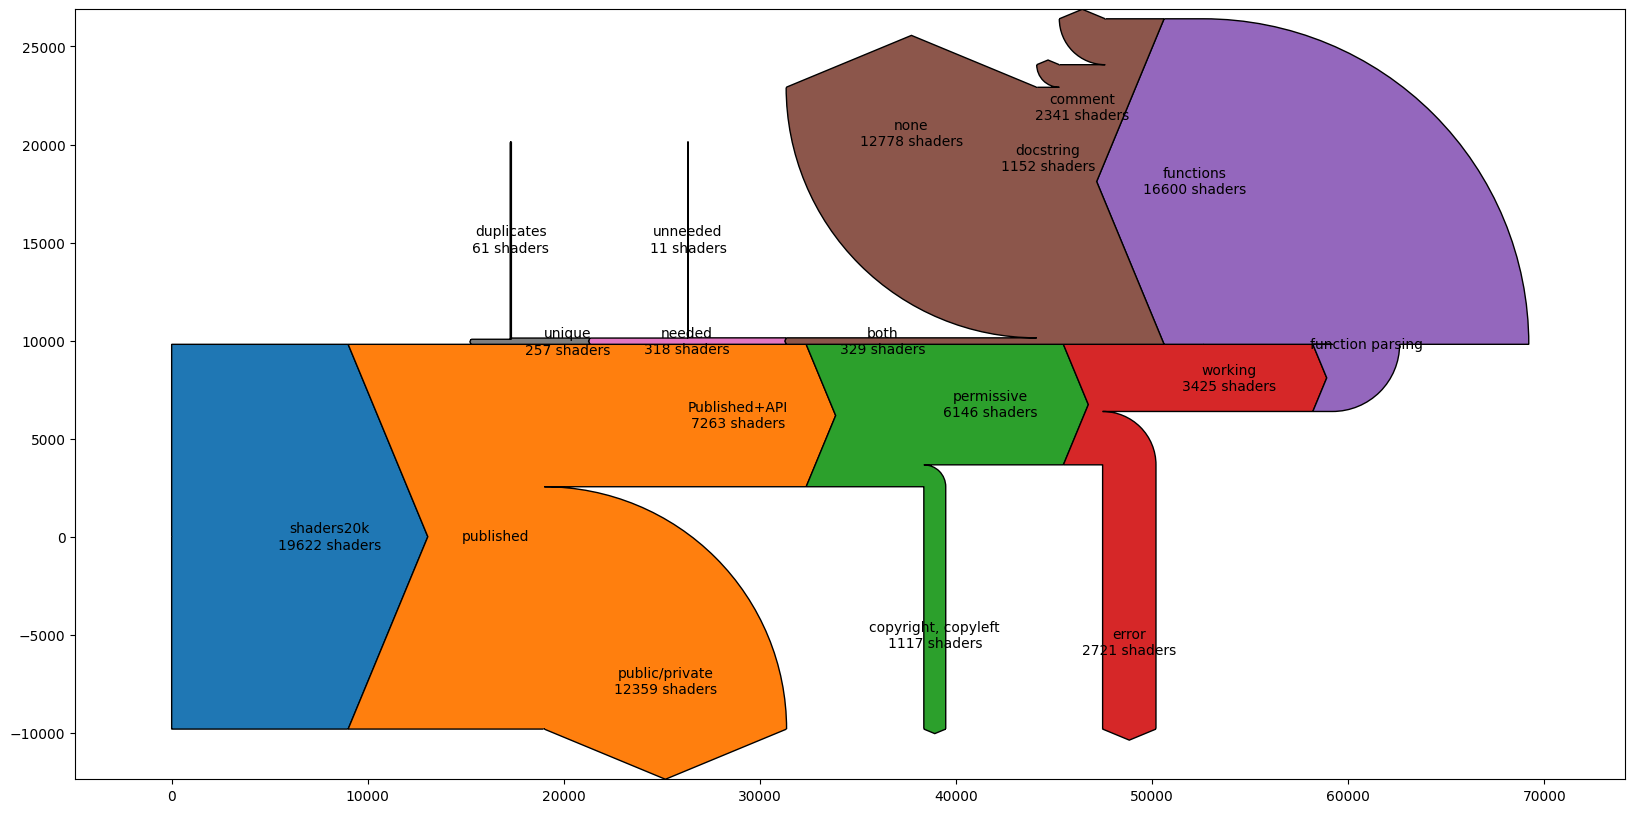

In [ ]:
# making a river plot (sankey diagram) of all out filtering steps
# keeping track of number of functions and then in backets (number of shader programs)
# filtering steps are in this order:
# 1. on shader programs: published, license, test,
# 2. on functions: comment+docstring, needed, deduplicate

program_filter_steps = [num_all, num_public_api, num_permissive, num_working]
import matplotlib.pyplot as plt
from matplotlib.sankey import Sankey
plt.figure(figsize=(20,10))
plot = Sankey(head_angle=135, ax=plt.gca(), offset=-5000, unit=" shaders")
# easily add a secondary data source?
plot.add(flows=[-num_all], labels=["shaders20k"], pathlengths=[9000])
plot.add(flows=[num_all, -num_public_api, -(num_all-num_public_api)], patchlabel="published", labels=[None,"Published+API", "public/private"], pathlengths=[5000, 1000, 0], orientations=[0,0,-1], prior=0, connect=(0,0), trunklength=5000)
plot.add(flows=[num_public_api, -num_permissive, -(num_public_api-num_permissive)], labels=[None,"permissive", "copyright, copyleft"], pathlengths=[1000, 6000, (num_all-num_public_api)], orientations=[0,0,-1], prior=1, connect=(1,0), trunklength=5000)
plot.add(flows=[num_permissive, -num_working, -(num_permissive-num_working)], labels=[None, "working", "error"], pathlengths=[2000, 8000, (num_all-num_permissive)], orientations=[0,0,-1], prior=2, connect=(1,0))

# no we switch to function level
plot.add(flows=[num_working, -len(func_df)],prior=3, connect=(1,0),orientations=[1], patchlabel="function parsing", labels=[None, "functions"], pathlengths=[1000, 2000]) #need to change unit?
# add function with comment and docstring = 329
plot.add(flows=[len(func_df), -xtab.iloc[1,1], -xtab.iloc[0,0], -xtab.iloc[0,1], -xtab.iloc[1,0]],prior=4, connect=(1,0),orientations=[0,0,-1,-1,-1], labels=[None,"both", "none", "docstring","comment"], pathlengths=[3000, 0, 0, 0, 0])
# only needed functions = 318
plot.add(flows=[xtab.iloc[1,1], -318, -11],prior=5, connect=(1,0),orientations=[0, 0, -1], labels=[None,"needed", "unneeded"], pathlengths=[5000, 5000, 10000])
# deduplicated = 257
plot.add(flows=[318, -len(both_df), -(318-len(both_df))],prior=6, connect=(1,0),orientations=[0, 0, -1], labels=[None, "unique", "duplicates"], pathlengths=[4000, 2000, 10000])

# TODO: fancy this up - maybe figure out a scale
# TODO: refactor this all into a function or generator to make the syntax less horrible.
plot.finish()
plt.savefig("../Thesis/report/texs/charts/data_filtering.png")
plt.show()

<Axes: title={'center': 'unique_header'}, xlabel='date'>

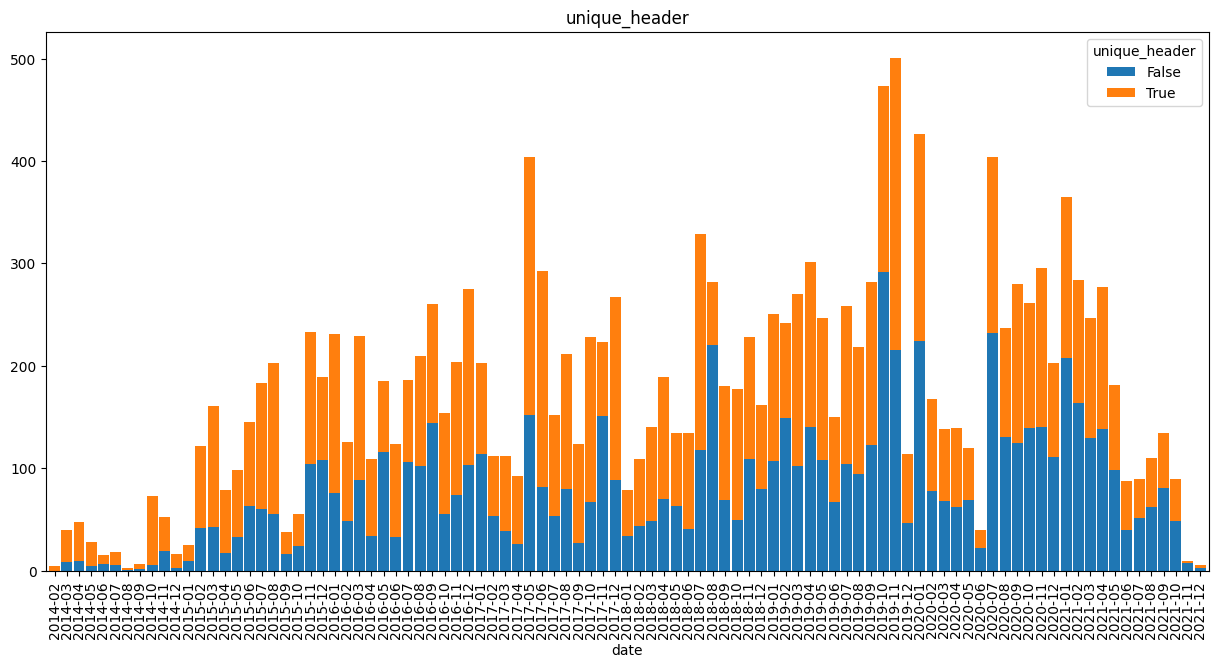

In [ ]:
# plot unique headers per month
# only looking at our "permissive" subset.
# tag every function as unique until it shows up twice (we use the header, iterate by time)
for i, row in tqdm(func_df.iterrows()):
    if func_df.loc[:i,"header"].eq(row["header"]).sum() > 1:
        func_df.at[i, "unique_header"] = False
    else:
        func_df.at[i, "unique_header"] = True

plot_per_month("unique_header", stretched=False, data=func_df, legend=True)

# Extension with API data

### only downloaded years 2020 till 2023 for now. It takes around 1 hour per year....

there is ~ 32k shaders on the API.
we need to apply a few extra filters and then join them with the above...

In [18]:
import os 
import jsonlines
import datasets
import pandas as pd


# awful code snippet pending https://github.com/huggingface/datasets/issues/7092 to use load_dataset instead (with both parts maybe).
api_files = os.listdir("./data/annotated/api")

api_files = [f"./data/annotated/api/{f}" for f in api_files]

api_file_contents = []
for f in api_files:
    with jsonlines.open(f) as reader:
        for obj in reader:
            api_file_contents.append(obj)

ds_api = datasets.Dataset.from_list(api_file_contents)

df_api = ds_api.to_pandas()

df_api["date"] = pd.to_datetime(df_api["date"].astype(int), unit="s")

num_all = len(df_api)
print(f"{num_all=}")

num_all=17383


In [19]:

# Filter 1: only shaders that are single pass (as in they don't have buffer passes etc)
# TODO: sound could be allowed, since it doesn't impact the image.

# TODO: maybe use common_code as that is trivially to combine?
print(f'number of shaders with common code={df_api.loc[df_api["common_code"] != ""].shape[0]}')
other_passes = [col for col in df_api.columns if col.endswith("_code") and col not in ("image_code")] #, "common_code", "souncd_code"

df_api = df_api[(df_api.loc[:,other_passes] == "").all(axis=1)]
num_single_pass = len(df_api)
print(f"{num_single_pass=}")


number of shaders with common code=4255
num_single_pass=11284


In [20]:
# Filter 2: only shaders that don't require inputs (for the image_pass which is left now)
# df_api["image_inputs"].apply(len).value_counts() # -> there is quite something
# TODO: maybe only some channel_types are bad... perhaps keep the ones we support (.complete)

df_api = df_api[df_api["image_inputs"].apply(len) == 0]
num_no_inputs = len(df_api)
print(f"{num_no_inputs=}")

num_no_inputs=8617


In [21]:
# Filter 3: overlap with the shaders20k data.
# we keep the "older" variant from the shaders20k dataset because that is static and won't change.

ids_20k = set(df["id"])

df_api = df_api[~df_api["id"].isin(ids_20k)]
num_new = len(df_api)
print(f"{num_new=}")

NameError: name 'df' is not defined

### combine and use similar filters as above...

In [1]:
# puttint it all together
import os
import jsonlines
import pandas as pd
import requests


def load_data(data_dir: os.PathLike) -> pd.DataFrame:
    lines = []
    for file in os.listdir(data_dir):
        if file.endswith(".jsonl"):
            with jsonlines.open(os.path.join(data_dir, file)) as reader:
                for obj in reader:
                    lines.append(obj)

    return pd.DataFrame(lines)


def filter_public_api(dataframe: pd.DataFrame, **kwargs) -> pd.DataFrame:
    """
    only keep shaders that are published to the API.
    """
    # TODO: Publish API shouldn't be in raw or annotated, this needs to be fixed in both datahalves.
    return dataframe[dataframe["published"].isin(["Public API", 3])]


def filter_licenses(dataframe: pd.DataFrame, keep_base=False, **kwargs) -> pd.DataFrame:
    """
    only keep permissive licenses.
    """
    permissive_list = requests.get("https://huggingface.co/datasets/bigcode-data/license_list/resolve/main/permissive_licenses.txt").content.decode("utf-8").split()
    permissive_list = [l.lower() for l in permissive_list]
    if keep_base:
        permissive_list.append("CC-BY-NC-SA-3.0")
    return dataframe[dataframe["license"].isin(permissive_list)]


def filter_single_pass(dataframe: pd.DataFrame, **kwargs) -> pd.DataFrame:
    """
    only keep shaders that are single pass.
    """
    other_passes = [col for col in dataframe.columns if col.endswith("_code") and col not in ("image_code")]
    #TODO: consider keeping sound_code and common_code (the later one needs to be prepended to the image_code)
    return dataframe[(dataframe.loc[:,other_passes] == "").all(axis=1)]


def filter_no_inputs(dataframe: pd.DataFrame, **kwargs) -> pd.DataFrame:
    """
    only keep shaders that don't require inputs.
    to be used after you filtered for single pass shaders.
    """
    # TODO: consider keeping some channel_types
    return dataframe[dataframe["image_inputs"].apply(len) == 0]

def filter_working(dataframe: pd.DataFrame, untested=False, **kwargs) -> pd.DataFrame:
    """
    only keep shaders that are working.
    """

    # TODO: testing needs to really work before we can rely on this
    drop_values = ["error", "panic", "timeout", "timedout", "valid", "untested"]
    keep_values = ["ok"]
    if untested:
        drop_values.remove("untested")
        keep_values.append("untested")
    return dataframe[dataframe["test"].isin(keep_values)]

PROGRAM_FILTERS = [filter_public_api, filter_licenses, filter_single_pass, filter_no_inputs, filter_working]

def filter_programs(dataframe: pd.DataFrame, filters=PROGRAM_FILTERS, **kwargs) -> pd.DataFrame:
    """
    apply a series of filters and print the resulting numbers
    kwargs are passed to the filters
    untested: keep untested shaders (default: False)
    keep_base: keep the base license (default: False)
    """
    # TODO: add plotting into sankey?
    print(len(dataframe))

    for f in filters:
        dataframe = f(dataframe, **kwargs)
        print(f"{len(dataframe)} shaderprograms remaining after {f.__name__}")
    return dataframe


def combine_datasets(base_data, add_data):
    """
    combine two datasets, keeping the base data.
    """
    ids_base = set(base_data["id"])
    return pd.concat([base_data, add_data[~add_data["id"].isin(ids_base)]])


api_df = load_data("./data/annotated/api")
s20k_df = load_data("./data/annotated")
api_df = filter_programs(api_df, untested=True, keep_base=False)
s20k_df = filter_programs(s20k_df, untested=True, keep_base=False)

combined_df = combine_datasets(s20k_df, api_df)
print(len(combined_df))



17383
17383 shaderprograms remaining after filter_public_api
805 shaderprograms remaining after filter_licenses
594 shaderprograms remaining after filter_single_pass
459 shaderprograms remaining after filter_no_inputs
459 shaderprograms remaining after filter_working
19622
7263 shaderprograms remaining after filter_public_api
408 shaderprograms remaining after filter_licenses
408 shaderprograms remaining after filter_single_pass
345 shaderprograms remaining after filter_no_inputs
195 shaderprograms remaining after filter_working
586


In [17]:
# expand to functions and then do function filters
 
from wgpu_shadertoy import api


def expand_functions(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    # TODO: likely redundant, since we keep everything... might need some cleanup instead
    cols_to_keep = ["id", "date", "image_code", "functions", "func_bytes"]
    #function byte indicies: start_comment, start_header, end_header, end_docstring, end_function
    func_parts = ["comment", "header", "docstring", "body"]

    # TODO: do we need the whole functions for anything downstream?
    dataframe["functions_"] = dataframe["functions"] # make a copy to keep it past explode
    func_df = dataframe.explode("functions")
    func_df.rename(columns={"functions": "func_bytes", "functions_": "functions"}, inplace=True)
    func_df.dropna(subset=["func_bytes"], inplace=True) # some shaders got not functions parsed ? -> TODO: check the tree-sitter.has_error() result?
    func_df.reset_index(inplace=True)
    for row_idx, row in func_df.iterrows():
        # print(row_idx, row)
        # break
        code = row["image_code"]
        code_bytes = bytes(code, encoding="utf-8")
        # func_bytes = row["func_bytes"]
        for idx, part in enumerate(func_parts):
            start = row["func_bytes"][idx]
            end = row["func_bytes"][idx+1]
            func_df.at[row_idx, part] = code_bytes[start:end].decode(encoding="utf-8")
        
    func_df.drop(columns=func_df.columns.difference(cols_to_keep + func_parts), inplace=True)
    func_df["date"] = pd.to_datetime(func_df["date"].astype(int), unit="s")

    return func_df

def filter_has_context(dataframe: pd.DataFrame, context="comment") -> pd.DataFrame:
    """
    only keep functions that have a specific context. (not exclusive)
    context: one of "comment", "docstring", "both", "none"
    """
    # TODO: not all are implemented
    if context == "comment":
        return dataframe[dataframe["comment"] != ""]
    elif context == "docstring":
        return dataframe[dataframe["docstring"] != ""]
    elif context == "both":
        return dataframe[(dataframe["comment"] != "") & (dataframe["docstring"] != "")]
    elif context == "none":
        raise NotImplementedError(f"not implemented yet for context: {context}")
    else:
        raise ValueError(f"unknown context: {context}")

# TODO: combine construct_inp and filter_has_context into one function maybe?
def construct_inp(dataframe: pd.DataFrame, context="comment") -> pd.DataFrame:
    """
    adds the model_inp column based on the context.
    """
    if context == "comment":
        dataframe["model_inp"] = dataframe["comment"] + dataframe["header"]
    elif context == "docstring":
        dataframe["model_inp"] = dataframe["header"] + dataframe["docstring"]
    elif context == "both":
        dataframe["model_inp"] = dataframe["comment"] + dataframe["header"] + dataframe["docstring"]
    elif context == "none":
        dataframe["model_inp"] = dataframe["header"]
    else:
        raise ValueError(f"unknown context: {context}")
    return dataframe

def filter_duplicates(dataframe: pd.DataFrame, sort_by="date") -> pd.DataFrame:
    """
    only keeps unique model_inp values. 
    sort_by specifies a column to sort by and keep the top value of. (default is "date")
    the sorting is not kept
    """
    if sort_by not in dataframe.columns:
        raise ValueError(f"unknown column to sort by: {sort_by}")
    dataframe.sort_values(by=sort_by, inplace=True)
    out_df = dataframe.drop_duplicates("model_inp")
    # undo the sort
    return out_df.sort_index()

def filter_needed(dataframe: pd.DataFrame) -> pd.DataFrame:
    """
    only keep functions that are needed. By running the shader with the function removed and seeing if it errors...
    """
    #TODO: decide how to proceed...
    pass
    raise NotImplementedError("not implemented yet")




func_df = expand_functions(combined_df)
print(len(func_df))
func_df = filter_has_context(func_df, context="comment")
print(len(func_df))
func_df = construct_inp(func_df, context="comment")
print(len(func_df)) # shouldn't change
func_df = filter_duplicates(func_df)
print(len(func_df))
func_df["body"].apply(len).describe()
# func_df["id"].value_counts()

4681
984
984
719


count      719.000000
mean       481.484006
std       1950.536128
min         18.000000
25%         93.000000
50%        203.000000
75%        471.500000
max      49803.000000
Name: body, dtype: float64

In [18]:
print(func_df["id"].nunique()) # our 719 functions are just from 290 programs?
func_df["header"].str.split(" ").apply(lambda x: x[0]).value_counts()
# func_df["header"].str.startswith("void").sum()

290


header
float              378
vec3               154
vec2                79
vec4                52
void                19
mat3                 9
bound3               5
v33                  5
bool                 4
Surface              2
tilingVal3D          2
uint                 2
int                  1
Ray                  1
uvec4                1
cast_ray_result      1
hexParams            1
ivec2                1
ivec3                1
ivec4                1
Name: count, dtype: int64